<a href="https://colab.research.google.com/github/vphcap-res/DOA_deep_learning/blob/main/DOA_NN_20250213-0101-Finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install requirements**

In [1]:
#import os
#print(os.listdir())  # List all files in the current directory

In [2]:
# Install the dependencies from requirements.txt
#!pip install -r /content/requirements.txt

# Verify that packages are installed
#!pip freeze

# **Data prep**

In [3]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os

In [4]:
# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure full determinism in TensorFlow operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

print("✅ Random seed set. Training will be reproducible.")

✅ Random seed set. Training will be reproducible.


In [5]:
# Ensure deterministic TensorFlow behavior
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [6]:
# Uploaded file
df = pd.read_excel('DOA-data_65-66_for_NN.xlsx')

In [7]:
# Select relevant columns
columns_to_select = ['head', 'age', 'bw', 'lairagetemp', 'season', 'timetransport', 'durationtransport', 'lairagetime', 'classdoa']
df2 = df[columns_to_select]

In [8]:
# Encode the target variable (classdoa)
label_encoder = LabelEncoder()
df2.loc[:, 'classdoa'] = label_encoder.fit_transform(df2['classdoa'])
target = to_categorical(df2['classdoa'])  # One-hot encode the target variable

# **Train-test split**
**10-fold CV**

In [9]:
# Perform stratified splitting before preprocessing
predictors = df2.drop('classdoa', axis=1)

In [14]:
# ✅ Debugging and Fixing Final Model Training Process

import pandas as pd

# Check for missing categorical encoding on the final train and test sets
categorical_cols = ['season', 'timetransport']

# ✅ Step 1: Split Data into Train (80%) and Test (20%) BEFORE CV
X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, test_size=0.2, random_state=SEED, stratify=target
)

# Ensure categorical columns exist before encoding
existing_categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Apply one-hot encoding to training and test sets
if existing_categorical_cols:
    X_train = pd.get_dummies(X_train, columns=existing_categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=existing_categorical_cols, drop_first=True)

    # Ensure feature consistency between training and test sets
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Check if all columns are numeric (should not contain strings)
print("\n✅ Checking Data Types of X_train (Final Training Set):\n", X_train.dtypes)
print("\n✅ Checking Data Types of X_test (Final Test Set):\n", X_test.dtypes)

# Check if any NaN values exist after processing
print("\n⚠️ Checking for Missing Values in X_train:\n", X_train.isnull().sum())
print("\n⚠️ Checking for Missing Values in X_test:\n", X_test.isnull().sum())

# Check shapes to ensure X_train and X_test match before training
print("\n✅ Shape of X_train:", X_train.shape)
print("✅ Shape of X_test:", X_test.shape)

# Check if target labels are properly formatted
print("\n✅ Checking y_train Shape:", y_train.shape)
print("✅ Checking y_test Shape:", y_test.shape)


✅ Checking Data Types of X_train (Final Training Set):
 head                       int64
age                        int64
bw                       float64
lairagetemp              float64
durationtransport          int64
lairagetime                int64
season_Summer               bool
season_Winter               bool
timetransport_Morning       bool
timetransport_Night         bool
dtype: object

✅ Checking Data Types of X_test (Final Test Set):
 head                       int64
age                        int64
bw                       float64
lairagetemp              float64
durationtransport          int64
lairagetime                int64
season_Summer               bool
season_Winter               bool
timetransport_Morning       bool
timetransport_Night         bool
dtype: object

⚠️ Checking for Missing Values in X_train:
 head                     0
age                      0
bw                       0
lairagetemp              0
durationtransport        0
lairagetime            

## **Experiments: Selection of baseline model**

In [17]:
from sklearn.model_selection import StratifiedKFold

In [18]:
# ✅ Step 2: Define Model Architectures for Comparison
model_configs = [
    {"name": "Model 1", "layers": [100]},              # 1 hidden layer, 100 neurons
    {"name": "Model 2", "layers": [100, 100]},         # 2 hidden layers, 100 neurons each
    {"name": "Model 3", "layers": [200]},              # 1 hidden layer, 200 neurons
    {"name": "Model 4", "layers": [200, 200]}          # 2 hidden layers, 200 neurons each
]

# ✅ Step 3: Perform 10-Fold Cross-Validation on Training Set
k = 10
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Store cross-validation results
cv_results = {}

# Iterate through different model architectures
for model_config in model_configs:
    print(f"\n🔹 Running Cross-Validation for {model_config['name']}...")

    # Store performance across folds
    accuracy_scores = []
    loss_scores = []

    # Define EarlyStopping
    early_stopping_monitor = EarlyStopping(patience=3, restore_best_weights=True)

    # Cross-validation loop
    for fold, (train_index, val_index) in enumerate(kf.split(X_train, np.argmax(y_train, axis=1))):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Convert categorical features (if they exist)
        categorical_cols = ['season', 'timetransport']
        existing_categorical_cols = [col for col in categorical_cols if col in X_train_fold.columns]
        if existing_categorical_cols:
            X_train_fold = pd.get_dummies(X_train_fold, columns=existing_categorical_cols, drop_first=True)
            X_val_fold = pd.get_dummies(X_val_fold, columns=existing_categorical_cols, drop_first=True)
            X_val_fold = X_val_fold.reindex(columns=X_train_fold.columns, fill_value=0)

        # Define model architecture dynamically
        model = Sequential()
        model.add(Input(shape=(X_train_fold.shape[1],)))  # Input layer
        for neurons in model_config["layers"]:  # Add hidden layers
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(2, activation='softmax'))  # Output layer

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=30, verbose=0, callbacks=[early_stopping_monitor], validation_data=(X_val_fold, y_val_fold))

        # Evaluate the model
        loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracy_scores.append(accuracy)
        loss_scores.append(loss)

        # Print performance per fold
        print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}, Loss = {loss:.4f}")

    # Store cross-validation results
    cv_results[model_config["name"]] = {
        "mean_accuracy": np.mean(accuracy_scores),
        "std_accuracy": np.std(accuracy_scores),
        "mean_loss": np.mean(loss_scores),
        "std_loss": np.std(loss_scores)
    }


🔹 Running Cross-Validation for Model 1...
Fold 1: Accuracy = 0.7948, Loss = 0.4656
Fold 2: Accuracy = 0.8116, Loss = 0.4413
Fold 3: Accuracy = 0.7979, Loss = 0.4891
Fold 4: Accuracy = 0.7614, Loss = 0.5105
Fold 5: Accuracy = 0.7812, Loss = 0.5330
Fold 6: Accuracy = 0.7812, Loss = 0.6337
Fold 7: Accuracy = 0.7382, Loss = 0.5797
Fold 8: Accuracy = 0.7808, Loss = 0.4946
Fold 9: Accuracy = 0.7945, Loss = 0.5677
Fold 10: Accuracy = 0.7854, Loss = 0.6861

🔹 Running Cross-Validation for Model 2...
Fold 1: Accuracy = 0.7948, Loss = 0.4782
Fold 2: Accuracy = 0.8131, Loss = 0.5264
Fold 3: Accuracy = 0.7827, Loss = 0.5191
Fold 4: Accuracy = 0.7720, Loss = 0.6588
Fold 5: Accuracy = 0.7492, Loss = 0.5242
Fold 6: Accuracy = 0.7827, Loss = 0.6657
Fold 7: Accuracy = 0.7732, Loss = 0.6511
Fold 8: Accuracy = 0.8067, Loss = 0.4953
Fold 9: Accuracy = 0.7976, Loss = 0.4931
Fold 10: Accuracy = 0.7884, Loss = 0.7000

🔹 Running Cross-Validation for Model 3...
Fold 1: Accuracy = 0.7964, Loss = 0.4909
Fold 2: 

In [19]:
# ✅ Step 4: Select Best Model and Train on Full Training Set
best_model_config = max(cv_results, key=lambda x: cv_results[x]["mean_accuracy"])
print(f"\n🎯 Best Model Selected: {best_model_config}")

# Retrieve best model architecture
best_layers = next(m["layers"] for m in model_configs if m["name"] == best_model_config)

# Define final model with best architecture
final_model = Sequential()
final_model.add(Input(shape=(X_train.shape[1],)))
for neurons in best_layers:
    final_model.add(Dense(neurons, activation='relu'))
final_model.add(Dense(2, activation='softmax'))  # Output layer

# Compile final model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train final model on full training set
final_model.fit(X_train, y_train, epochs=30, verbose=1)

# ✅ Step 5: Evaluate on Unseen Test Set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"\n📌 Final Model Test Accuracy: {test_accuracy:.4f}")
print(f"📌 Final Model Test Loss: {test_loss:.4f}")


🎯 Best Model Selected: Model 2
Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6644 - loss: 5.5500
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6972 - loss: 1.1530
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7296 - loss: 1.0736
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7031 - loss: 1.5042
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7054 - loss: 1.0449
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7378 - loss: 0.8411
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7104 - loss: 1.1296
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7061 - loss: 0.9788
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7262 - loss: 0.8216
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7111 - loss: 0.9363
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7316 - loss: 0.7795
Epoch 12/30
206/206 

# **Model 2 Test Performance**

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# ✅ Step 1: Get Model Predictions
y_pred_prob = final_model.predict(X_test)  # Get probability outputs
y_pred = np.argmax(y_pred_prob, axis=1)    # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)         # Convert one-hot labels to class labels

# ✅ Step 2: Compute Performance Metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Step 3: Print the Performance Metrics
print("\n📊 **Final Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Step 4: Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 **Final Model Performance on Test Set** 📊
✅ Accuracy: 0.7895
✅ Precision: 0.7532
✅ Recall: 0.7895
✅ F1-score: 0.7214
✅ AUC Score: 0.7404

🔍 **Detailed Classification Report:**
              precision    recall  f1-score   support

           0       0.60      0.08      0.15       356
           1       0.80      0.98      0.88      1288

    accuracy                           0.79      1644
   macro avg       0.70      0.53      0.51      1644
weighted avg       0.75      0.79      0.72      1644



# **Model Optimization**

In [22]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ✅ Define Hyperparameters for Fine-Tuning
learning_rate = 0.001  # Optimized learning rate
dropout_rate = 0.3  # Dropout for regularization
batch_size = 32  # Batch size for stable updates
epochs = 50  # Increase training time for better convergence

# ✅ Build the Fine-Tuned Model
fine_tuned_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input layer

    Dense(128, activation='relu'),  # More neurons
    BatchNormalization(),  # Normalize activations
    Dropout(dropout_rate),  # Regularization

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(2, activation='softmax')  # Output layer (binary classification)
])

# ✅ Compile the Model with Optimized Learning Rate
optimizer = Adam(learning_rate=learning_rate)
fine_tuned_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Add Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# ✅ Train the Fine-Tuned Model
history = fine_tuned_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[lr_scheduler]
)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = fine_tuned_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = fine_tuned_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Fine-Tuned Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6402 - loss: 0.8087 - val_accuracy: 0.7841 - val_loss: 0.5483 - learning_rate: 0.0010
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7616 - loss: 0.5607 - val_accuracy: 0.7847 - val_loss: 0.4962 - learning_rate: 0.0010
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7747 - loss: 0.5259 - val_accuracy: 0.7835 - val_loss: 0.5002 - learning_rate: 0.0010
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7816 - loss: 0.5144 - val_accuracy: 0.7828 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 5/50
201/206 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7815 - loss: 0.4980
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7815 - loss: 0.4981 - val_accuracy: 0.5973 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7903 - loss: 0.4900 - v

## **Hyperparameter Optimization with Manual Hyperparameter Search**

In [23]:
from tensorflow.keras.layers import LeakyReLU

# Define a function to train and evaluate different hyperparameters
def train_model(learning_rate, dropout_rate, neurons):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(neurons, activation=LeakyReLU(alpha=0.1)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(neurons//2, activation=LeakyReLU(alpha=0.1)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(2, activation='softmax')  # Output layer
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    return test_accuracy

# Define hyperparameter values to test
learning_rates = [0.001, 0.0005, 0.0001]
dropout_rates = [0.2, 0.3, 0.4]
neurons_options = [64, 128, 256]

best_accuracy = 0
best_params = {}

# Iterate over different hyperparameter combinations
for lr in learning_rates:
    for dr in dropout_rates:
        for neurons in neurons_options:
            print(f"\n🔹 Testing Model with LR={lr}, Dropout={dr}, Neurons={neurons}")
            accuracy = train_model(learning_rate=lr, dropout_rate=dr, neurons=neurons)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"learning_rate": lr, "dropout_rate": dr, "neurons": neurons}

# Print the best hyperparameters
print("\n🎯 Best Hyperparameters Found:")
print(best_params)


🔹 Testing Model with LR=0.001, Dropout=0.2, Neurons=64
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6516 - loss: 0.7242 - val_accuracy: 0.7828 - val_loss: 0.5151
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7724 - loss: 0.5371 - val_accuracy: 0.7835 - val_loss: 0.4970
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7784 - loss: 0.5179 - val_accuracy: 0.7847 - val_loss: 0.4886
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7859 - loss: 0.4896 - val_accuracy: 0.7889 - val_loss: 0.5305
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7881 - loss: 0.4778 - val_accuracy: 0.7847 - val_loss: 0.6705
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7943 - loss: 0.4715 - val_accuracy: 0.6758 - val_loss: 0.6025
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7893 - loss: 0.4714 - val_accuracy: 0.7853 - val_loss: 0.4644
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7987 - loss: 0.4648 - val_accuracy: 0.7883 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6326 - loss: 0.7435 - val_accuracy: 0.7676 - val_loss: 0.5694
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7701 - loss: 0.5460 - val_accuracy: 0.2251 - val_loss: 1.8487
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7853 - loss: 0.5065 - val_accuracy: 0.7731 - val_loss: 0.5273
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7761 - loss: 0.5041 - val_accuracy: 0.7883 - val_loss: 0.4698
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7900 - loss: 0.4804 - val_accuracy: 0.7883 - val_loss: 0.4641
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7862 - loss: 0.4737 - val_accuracy: 0.7853 - val_loss: 0.5144
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7955 - loss: 0.4701 - val_accuracy: 0.7871 - val_loss: 0.4677
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7947 - loss: 0.4651 - val_accuracy: 0.7877 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6551 - loss: 0.7328 - val_accuracy: 0.7701 - val_loss: 0.5423
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7779 - loss: 0.5349 - val_accuracy: 0.7865 - val_loss: 0.4976
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7830 - loss: 0.5129 - val_accuracy: 0.7561 - val_loss: 0.5418
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7830 - loss: 0.4976 - val_accuracy: 0.7847 - val_loss: 0.4828
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7844 - loss: 0.4940 - val_accuracy: 0.7932 - val_loss: 0.4830
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7859 - loss: 0.4787 - val_accuracy: 0.6283 - val_loss: 0.6352
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7911 - loss: 0.4738 - val_accuracy: 0.7950 - val_loss: 0.4723
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7962 - loss: 0.4700 - val_accuracy: 0.7853 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6043 - loss: 0.7736 - val_accuracy: 0.7828 - val_loss: 0.5101
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7587 - loss: 0.5672 - val_accuracy: 0.7847 - val_loss: 0.4962
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7701 - loss: 0.5354 - val_accuracy: 0.7853 - val_loss: 0.4934
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7839 - loss: 0.5083 - val_accuracy: 0.7877 - val_loss: 0.4704
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7882 - loss: 0.4913 - val_accuracy: 0.7841 - val_loss: 0.5037
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7925 - loss: 0.4839 - val_accuracy: 0.7762 - val_loss: 0.5558
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7882 - loss: 0.4804 - val_accuracy: 0.7847 - val_loss: 0.4777
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7924 - loss: 0.4761 - val_accuracy: 0.4629 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6427 - loss: 0.8244 - val_accuracy: 0.7859 - val_loss: 0.5264
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7750 - loss: 0.5435 - val_accuracy: 0.2220 - val_loss: 1.2122
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7760 - loss: 0.5174 - val_accuracy: 0.5195 - val_loss: 0.7062
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7856 - loss: 0.4957 - val_accuracy: 0.7853 - val_loss: 0.4949
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7884 - loss: 0.4881 - val_accuracy: 0.7859 - val_loss: 0.5102
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7897 - loss: 0.4862 - val_accuracy: 0.7895 - val_loss: 0.4678
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7932 - loss: 0.4768 - val_accuracy: 0.7853 - val_loss: 0.4714
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7922 - loss: 0.4749 - val_accuracy: 0.7865 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6603 - loss: 0.7508 - val_accuracy: 0.7853 - val_loss: 0.4948
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7696 - loss: 0.5457 - val_accuracy: 0.6837 - val_loss: 0.5916
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7789 - loss: 0.5112 - val_accuracy: 0.7883 - val_loss: 0.4740
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7801 - loss: 0.5006 - val_accuracy: 0.7901 - val_loss: 0.4681
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7877 - loss: 0.4863 - val_accuracy: 0.7865 - val_loss: 0.4827
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7908 - loss: 0.4748 - val_accuracy: 0.7865 - val_loss: 0.4882
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7898 - loss: 0.4720 - val_accuracy: 0.7859 - val_loss: 0.4868
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7947 - loss: 0.4706 - val_accuracy: 0.7889 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6135 - loss: 0.8422 - val_accuracy: 0.7828 - val_loss: 0.5159
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7431 - loss: 0.5868 - val_accuracy: 0.7847 - val_loss: 0.4936
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7701 - loss: 0.5257 - val_accuracy: 0.6916 - val_loss: 0.6098
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7851 - loss: 0.5092 - val_accuracy: 0.7877 - val_loss: 0.5052
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7885 - loss: 0.4881 - val_accuracy: 0.7950 - val_loss: 0.5257
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7908 - loss: 0.4819 - val_accuracy: 0.5377 - val_loss: 0.7019
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7843 - loss: 0.4849 - val_accuracy: 0.5961 - val_loss: 0.6683
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7931 - loss: 0.4754 - val_accuracy: 0.7877 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6169 - loss: 0.8546 - val_accuracy: 0.7847 - val_loss: 0.5073
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7522 - loss: 0.5891 - val_accuracy: 0.7865 - val_loss: 0.4895
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7783 - loss: 0.5259 - val_accuracy: 0.7865 - val_loss: 0.5074
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7776 - loss: 0.5094 - val_accuracy: 0.7853 - val_loss: 0.4773
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7896 - loss: 0.4919 - val_accuracy: 0.7859 - val_loss: 0.4897
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7833 - loss: 0.4857 - val_accuracy: 0.7634 - val_loss: 0.5643
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7959 - loss: 0.4829 - val_accuracy: 0.7853 - val_loss: 0.4744
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7951 - loss: 0.4742 - val_accuracy: 0.7847 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6283 - loss: 0.8882 - val_accuracy: 0.7202 - val_loss: 0.5849
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7667 - loss: 0.5802 - val_accuracy: 0.7798 - val_loss: 0.5267
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7711 - loss: 0.5534 - val_accuracy: 0.7682 - val_loss: 0.5582
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7732 - loss: 0.5222 - val_accuracy: 0.7859 - val_loss: 0.4891
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7825 - loss: 0.4961 - val_accuracy: 0.7859 - val_loss: 0.4725
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7900 - loss: 0.4826 - val_accuracy: 0.7871 - val_loss: 0.4722
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7884 - loss: 0.4745 - val_accuracy: 0.7318 - val_loss: 0.5965
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7913 - loss: 0.4733 - val_accuracy: 0.6527 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5790 - loss: 0.7322 - val_accuracy: 0.6709 - val_loss: 0.6304
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7343 - loss: 0.5834 - val_accuracy: 0.7810 - val_loss: 0.5387
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7569 - loss: 0.5482 - val_accuracy: 0.7281 - val_loss: 0.6057
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7745 - loss: 0.5146 - val_accuracy: 0.7853 - val_loss: 0.5189
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7832 - loss: 0.5080 - val_accuracy: 0.7841 - val_loss: 0.4875
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7814 - loss: 0.5007 - val_accuracy: 0.7853 - val_loss: 0.4996
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7904 - loss: 0.4862 - val_accuracy: 0.7865 - val_loss: 0.4750
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7920 - loss: 0.4777 - val_accuracy: 0.7853 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6327 - loss: 0.7555 - val_accuracy: 0.5377 - val_loss: 0.7006
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7508 - loss: 0.5602 - val_accuracy: 0.7853 - val_loss: 0.4960
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7724 - loss: 0.5253 - val_accuracy: 0.7871 - val_loss: 0.4816
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7812 - loss: 0.5180 - val_accuracy: 0.7877 - val_loss: 0.4808
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7804 - loss: 0.5035 - val_accuracy: 0.7853 - val_loss: 0.4790
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7880 - loss: 0.4822 - val_accuracy: 0.7914 - val_loss: 0.4678
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7888 - loss: 0.4873 - val_accuracy: 0.7859 - val_loss: 0.4957
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7912 - loss: 0.4829 - val_accuracy: 0.7932 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6084 - loss: 0.7749 - val_accuracy: 0.7251 - val_loss: 0.5718
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7606 - loss: 0.5417 - val_accuracy: 0.7798 - val_loss: 0.5162
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7736 - loss: 0.5212 - val_accuracy: 0.7895 - val_loss: 0.4785
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7769 - loss: 0.5146 - val_accuracy: 0.7883 - val_loss: 0.4761
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7826 - loss: 0.4934 - val_accuracy: 0.7914 - val_loss: 0.4746
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7891 - loss: 0.4932 - val_accuracy: 0.7245 - val_loss: 0.5633
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7931 - loss: 0.4798 - val_accuracy: 0.7883 - val_loss: 0.4724
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7894 - loss: 0.4901 - val_accuracy: 0.7889 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5587 - loss: 0.8788 - val_accuracy: 0.7859 - val_loss: 0.5049
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7035 - loss: 0.6284 - val_accuracy: 0.7859 - val_loss: 0.5436
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7516 - loss: 0.5577 - val_accuracy: 0.7281 - val_loss: 0.5965
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7728 - loss: 0.5374 - val_accuracy: 0.7895 - val_loss: 0.4715
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7825 - loss: 0.5042 - val_accuracy: 0.7859 - val_loss: 0.4872
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7787 - loss: 0.5099 - val_accuracy: 0.7853 - val_loss: 0.4825
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7818 - loss: 0.5074 - val_accuracy: 0.7871 - val_loss: 0.4804
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7930 - loss: 0.4857 - val_accuracy: 0.7859 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6053 - loss: 0.8388 - val_accuracy: 0.7822 - val_loss: 0.5906
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7338 - loss: 0.6019 - val_accuracy: 0.7828 - val_loss: 0.5075
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7590 - loss: 0.5711 - val_accuracy: 0.7816 - val_loss: 0.4895
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7736 - loss: 0.5287 - val_accuracy: 0.7816 - val_loss: 0.5019
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7750 - loss: 0.5243 - val_accuracy: 0.6642 - val_loss: 0.6147
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7849 - loss: 0.5024 - val_accuracy: 0.7956 - val_loss: 0.5083
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7837 - loss: 0.4920 - val_accuracy: 0.7877 - val_loss: 0.4709
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7888 - loss: 0.4912 - val_accuracy: 0.7950 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5963 - loss: 0.7994 - val_accuracy: 0.7780 - val_loss: 0.5259
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7462 - loss: 0.5754 - val_accuracy: 0.6046 - val_loss: 0.6403
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7677 - loss: 0.5412 - val_accuracy: 0.7926 - val_loss: 0.5078
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7799 - loss: 0.5178 - val_accuracy: 0.7853 - val_loss: 0.4698
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7852 - loss: 0.5073 - val_accuracy: 0.7865 - val_loss: 0.4896
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7876 - loss: 0.4899 - val_accuracy: 0.7074 - val_loss: 0.5763
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7903 - loss: 0.4801 - val_accuracy: 0.7828 - val_loss: 0.4788
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7885 - loss: 0.4797 - val_accuracy: 0.7877 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5799 - loss: 0.9241 - val_accuracy: 0.7822 - val_loss: 0.5504
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6962 - loss: 0.6740 - val_accuracy: 0.7804 - val_loss: 0.5137
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7298 - loss: 0.6263 - val_accuracy: 0.7835 - val_loss: 0.5008
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7582 - loss: 0.5721 - val_accuracy: 0.7835 - val_loss: 0.5029
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7640 - loss: 0.5525 - val_accuracy: 0.7853 - val_loss: 0.4926
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7701 - loss: 0.5381 - val_accuracy: 0.7828 - val_loss: 0.4921
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7805 - loss: 0.5182 - val_accuracy: 0.7828 - val_loss: 0.4909
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7788 - loss: 0.5169 - val_accuracy: 0.7828 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5501 - loss: 0.9607 - val_accuracy: 0.7810 - val_loss: 0.5660
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7092 - loss: 0.6604 - val_accuracy: 0.7828 - val_loss: 0.5257
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7467 - loss: 0.5983 - val_accuracy: 0.7828 - val_loss: 0.5037
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7648 - loss: 0.5586 - val_accuracy: 0.7853 - val_loss: 0.4949
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7675 - loss: 0.5382 - val_accuracy: 0.7828 - val_loss: 0.4853
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7776 - loss: 0.5160 - val_accuracy: 0.7835 - val_loss: 0.4883
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7887 - loss: 0.5046 - val_accuracy: 0.7847 - val_loss: 0.4730
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7882 - loss: 0.4870 - val_accuracy: 0.7859 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6069 - loss: 0.9034 - val_accuracy: 0.7822 - val_loss: 0.5114
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7265 - loss: 0.6366 - val_accuracy: 0.7871 - val_loss: 0.4947
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7580 - loss: 0.5849 - val_accuracy: 0.7828 - val_loss: 0.4926
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7624 - loss: 0.5475 - val_accuracy: 0.7871 - val_loss: 0.4816
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7742 - loss: 0.5218 - val_accuracy: 0.7889 - val_loss: 0.4738
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7783 - loss: 0.5150 - val_accuracy: 0.7865 - val_loss: 0.4710
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7831 - loss: 0.5032 - val_accuracy: 0.7968 - val_loss: 0.5210
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7878 - loss: 0.4853 - val_accuracy: 0.7877 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5675 - loss: 0.8140 - val_accuracy: 0.6788 - val_loss: 0.6642
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6176 - loss: 0.7399 - val_accuracy: 0.7676 - val_loss: 0.6030
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6601 - loss: 0.6801 - val_accuracy: 0.7701 - val_loss: 0.5785
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6710 - loss: 0.6479 - val_accuracy: 0.7713 - val_loss: 0.5545
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6925 - loss: 0.6344 - val_accuracy: 0.7707 - val_loss: 0.5341
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7192 - loss: 0.5982 - val_accuracy: 0.7828 - val_loss: 0.5244
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7377 - loss: 0.5792 - val_accuracy: 0.7828 - val_loss: 0.5098
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7425 - loss: 0.5668 - val_accuracy: 0.7859 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5054 - loss: 0.9862 - val_accuracy: 0.7835 - val_loss: 0.5625
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6141 - loss: 0.7475 - val_accuracy: 0.7549 - val_loss: 0.6084
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6747 - loss: 0.6756 - val_accuracy: 0.7695 - val_loss: 0.5829
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7031 - loss: 0.6300 - val_accuracy: 0.7835 - val_loss: 0.5420
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7318 - loss: 0.6004 - val_accuracy: 0.7835 - val_loss: 0.5138
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7392 - loss: 0.5934 - val_accuracy: 0.7847 - val_loss: 0.5062
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7598 - loss: 0.5649 - val_accuracy: 0.7853 - val_loss: 0.4949
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7498 - loss: 0.5752 - val_accuracy: 0.7835 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5386 - loss: 0.8357 - val_accuracy: 0.7828 - val_loss: 0.5910
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6319 - loss: 0.6856 - val_accuracy: 0.7798 - val_loss: 0.5494
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6773 - loss: 0.6505 - val_accuracy: 0.7841 - val_loss: 0.5164
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7233 - loss: 0.5923 - val_accuracy: 0.7877 - val_loss: 0.4912
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7440 - loss: 0.5617 - val_accuracy: 0.7865 - val_loss: 0.5031
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7605 - loss: 0.5444 - val_accuracy: 0.7865 - val_loss: 0.4792
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7682 - loss: 0.5328 - val_accuracy: 0.7883 - val_loss: 0.4769
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7739 - loss: 0.5255 - val_accuracy: 0.7859 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4932 - loss: 1.1823 - val_accuracy: 0.7561 - val_loss: 0.5102
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5455 - loss: 0.8920 - val_accuracy: 0.6058 - val_loss: 0.6508
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5852 - loss: 0.8256 - val_accuracy: 0.6855 - val_loss: 0.5806
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6262 - loss: 0.7349 - val_accuracy: 0.6983 - val_loss: 0.5708
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6507 - loss: 0.7180 - val_accuracy: 0.7275 - val_loss: 0.5651
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6942 - loss: 0.6399 - val_accuracy: 0.7646 - val_loss: 0.5324
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7015 - loss: 0.6273 - val_accuracy: 0.7670 - val_loss: 0.5238
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7137 - loss: 0.6183 - val_accuracy: 0.7682 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5393 - loss: 0.9988 - val_accuracy: 0.6794 - val_loss: 0.6043
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6018 - loss: 0.8347 - val_accuracy: 0.7068 - val_loss: 0.6224
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6345 - loss: 0.7754 - val_accuracy: 0.7500 - val_loss: 0.5855
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6548 - loss: 0.7032 - val_accuracy: 0.7713 - val_loss: 0.5465
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6990 - loss: 0.6446 - val_accuracy: 0.7804 - val_loss: 0.5242
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7034 - loss: 0.6494 - val_accuracy: 0.7871 - val_loss: 0.5213
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7266 - loss: 0.6123 - val_accuracy: 0.7871 - val_loss: 0.5099
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7324 - loss: 0.5909 - val_accuracy: 0.7847 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5683 - loss: 0.9456 - val_accuracy: 0.4045 - val_loss: 0.8233
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6246 - loss: 0.7981 - val_accuracy: 0.7670 - val_loss: 0.5647
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6803 - loss: 0.7000 - val_accuracy: 0.7908 - val_loss: 0.5188
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7034 - loss: 0.6503 - val_accuracy: 0.7871 - val_loss: 0.5035
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7253 - loss: 0.6232 - val_accuracy: 0.7828 - val_loss: 0.4958
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7418 - loss: 0.6038 - val_accuracy: 0.7859 - val_loss: 0.4922
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7583 - loss: 0.5782 - val_accuracy: 0.7865 - val_loss: 0.4868
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7560 - loss: 0.5835 - val_accuracy: 0.7859 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5303 - loss: 1.0741 - val_accuracy: 0.7798 - val_loss: 0.5525
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5911 - loss: 0.8687 - val_accuracy: 0.7774 - val_loss: 0.5389
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5917 - loss: 0.8303 - val_accuracy: 0.7676 - val_loss: 0.5622
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6314 - loss: 0.7560 - val_accuracy: 0.7695 - val_loss: 0.5490
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6450 - loss: 0.7391 - val_accuracy: 0.7725 - val_loss: 0.5384
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6725 - loss: 0.6963 - val_accuracy: 0.7701 - val_loss: 0.5314
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6809 - loss: 0.6536 - val_accuracy: 0.7762 - val_loss: 0.5202
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6920 - loss: 0.6404 - val_accuracy: 0.7841 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5575 - loss: 1.1387 - val_accuracy: 0.7415 - val_loss: 0.5708
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5923 - loss: 0.9138 - val_accuracy: 0.7597 - val_loss: 0.5823
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6336 - loss: 0.8282 - val_accuracy: 0.7725 - val_loss: 0.5534
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6428 - loss: 0.7733 - val_accuracy: 0.7828 - val_loss: 0.5220
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6696 - loss: 0.7440 - val_accuracy: 0.7871 - val_loss: 0.5132
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6857 - loss: 0.6970 - val_accuracy: 0.7853 - val_loss: 0.5106
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7172 - loss: 0.6405 - val_accuracy: 0.7859 - val_loss: 0.5039
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7129 - loss: 0.6656 - val_accuracy: 0.7828 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5397 - loss: 0.9712 - val_accuracy: 0.7822 - val_loss: 0.5440
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6022 - loss: 0.8211 - val_accuracy: 0.7816 - val_loss: 0.5461
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6570 - loss: 0.7354 - val_accuracy: 0.7883 - val_loss: 0.5091
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6691 - loss: 0.7039 - val_accuracy: 0.7835 - val_loss: 0.5057
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6963 - loss: 0.6631 - val_accuracy: 0.7847 - val_loss: 0.4915
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7210 - loss: 0.6218 - val_accuracy: 0.7847 - val_loss: 0.4920
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7256 - loss: 0.6169 - val_accuracy: 0.7835 - val_loss: 0.4912
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7460 - loss: 0.6009 - val_accuracy: 0.7835 - val_

In [24]:
# ✅ Train the Final Model with Best Hyperparameters
best_learning_rate = 0.0001
best_dropout_rate = 0.3
best_neurons = 256

# ✅ Define the Optimized Model
final_optimized_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(best_neurons, activation='relu'),
    BatchNormalization(),
    Dropout(best_dropout_rate),

    Dense(best_neurons//2, activation='relu'),
    BatchNormalization(),
    Dropout(best_dropout_rate),

    Dense(2, activation='softmax')  # Output layer
])

# ✅ Compile the Model
optimizer = Adam(learning_rate=best_learning_rate)
final_optimized_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the Model on Full Training Set
final_optimized_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = final_optimized_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = final_optimized_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Final Optimized Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5395 - loss: 0.9383 - val_accuracy: 0.4307 - val_loss: 0.8363
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5999 - loss: 0.8267 - val_accuracy: 0.7573 - val_loss: 0.6134
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6616 - loss: 0.7083 - val_accuracy: 0.7774 - val_loss: 0.5723
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6991 - loss: 0.6436 - val_accuracy: 0.7804 - val_loss: 0.5821
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7226 - loss: 0.6314 - val_accuracy: 0.7804 - val_loss: 0.5578
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7253 - loss: 0.6247 - val_accuracy: 0.7792 - val_loss: 0.5454
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7399 - loss: 0.5981 - val_accuracy: 0.7816 - val_loss: 0.5406
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7468 - loss: 0.5851 - val_accuracy: 0.

## **Improved Model (from fine_tuned_model)**

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ✅ Define New Hyperparameters
improved_learning_rate = 0.0005  # Slightly increased
improved_dropout_rate = 0.2  # Less dropout
improved_neurons = 128  # Reduce complexity

# ✅ Define the Improved Model
improved_model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(improved_neurons, activation='relu'),
    BatchNormalization(),
    Dropout(improved_dropout_rate),

    Dense(improved_neurons//2, activation='relu'),
    BatchNormalization(),
    Dropout(improved_dropout_rate),

    Dense(2, activation='softmax')  # Output layer
])

# ✅ Compile the Model
optimizer = Adam(learning_rate=improved_learning_rate)
improved_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Add a Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# ✅ Train the Improved Model
history = improved_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[lr_scheduler]
)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = improved_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = improved_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Improved Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5625 - loss: 0.8424 - val_accuracy: 0.7816 - val_loss: 0.5214 - learning_rate: 5.0000e-04
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7399 - loss: 0.5886 - val_accuracy: 0.7822 - val_loss: 0.5303 - learning_rate: 5.0000e-04
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7670 - loss: 0.5516 - val_accuracy: 0.7585 - val_loss: 0.5500 - learning_rate: 5.0000e-04
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7756 - loss: 0.5467 - val_accuracy: 0.7822 - val_loss: 0.5094 - learning_rate: 5.0000e-04
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7819 - loss: 0.5182 - val_accuracy: 0.7816 - val_loss: 0.5243 - learning_rate: 5.0000e-04
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7819 - loss: 0.5119 - val_accuracy: 0.7853 - val_loss: 0.4864 - learning_rate: 5.0000e-04
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 

# **SHAP Analysis**
## **✅ Select fine_tuned_model**

In [26]:
!pip install shap

In [27]:
import shap
import matplotlib.pyplot as plt

**Initialize the SHAP Explainer**

In [41]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure SHAP package is installed
!pip install shap

X_train_numeric = X_train.astype(np.float32)

# Initialize SHAP explainer with the trained model and dataset
explainer = shap.Explainer(fine_tuned_model, X_train_numeric)

# Compute SHAP values
shap_values = explainer(X_train_numeric)

ExactExplainer explainer: 6577it [11:00,  9.83it/s]                          


In [43]:
print("Feature Names in X_train:")
print(list(X_train.columns))

Feature Names in X_train:
['head', 'age', 'bw', 'lairagetemp', 'durationtransport', 'lairagetime', 'season_Summer', 'season_Winter', 'timetransport_Morning', 'timetransport_Night']


In [45]:
# Define custom feature names
custom_feature_names = {
    "lairagetemp": "Lairage temperature (°C)",
    "head": "Duck head count",
    "age": "Duck age (days)",
    "durationtransport": "Transport duration (min)",
    "bw": "Average body weight (kg)",
    "timetransport_Morning": "Time of transport: Morning",
    "lairagetime": "Lairage time (min)",
    "season_Winter": "Season: Winter",
    "timetransport_Night": "Time of transport: Night",
    "season_Summer": "Season: Summer"
}

In [46]:
# Define the correctly ordered feature names based on X_train.columns
ordered_feature_names = [
    "Duck head count",              # head
    "Duck age (days)",              # age
    "Average body weight (kg)",     # bw
    "Lairage temperature (°C)",     # lairagetemp
    "Transport duration (min)",     # durationtransport
    "Lairage time (min)",           # lairagetime
    "Season: Summer",               # season_Summer
    "Season: Winter",               # season_Winter
    "Time of transport: Morning",   # timetransport_Morning
    "Time of transport: Night"      # timetransport_Night
]

In [47]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure SHAP package is installed
!pip install shap

# ✅ Ensure X_train is numeric
X_train_numeric = X_train.astype(np.float32)

# ✅ Replace NaN and infinite values (if any)
X_train_numeric = np.nan_to_num(X_train_numeric)

# Apply renaming
X_train_renamed = pd.DataFrame(X_train_numeric, columns=X_train.columns).rename(columns=custom_feature_names)

**Summary Plot**

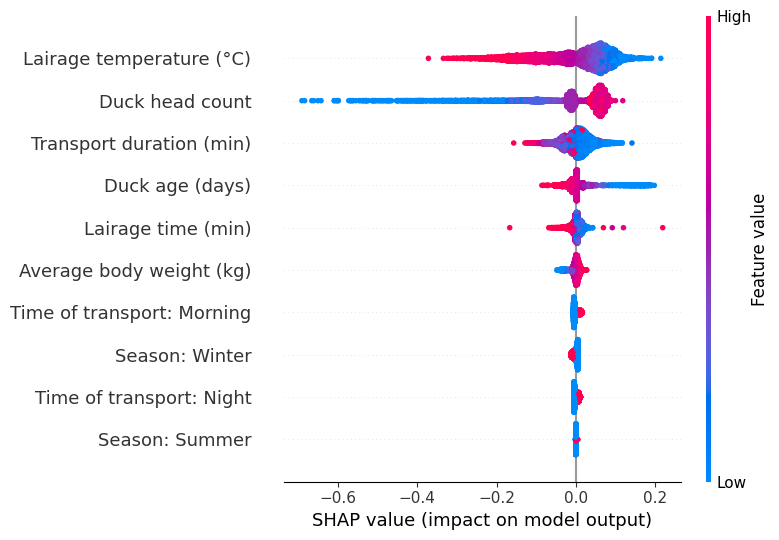

In [49]:
# ✅ Select SHAP values for the 'high' class (class index 1)
shap_values_high = shap_values.values[:, :, 1]  # Extracting class 1 (High DOA)

# ✅ Generate the SHAP beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_high,
    X_train_renamed,
    feature_names=ordered_feature_names,  # Ensure correct order
    max_display=10,
    show=False
)

# ✅ Save the plot with high resolution
plt.savefig("shap_summary_plot_beeswarm2.jpg", dpi=600, bbox_inches="tight")
plt.show()

## **Dependence Plot**

**transport duration VS Lairage temp**

<Figure size 640x480 with 0 Axes>

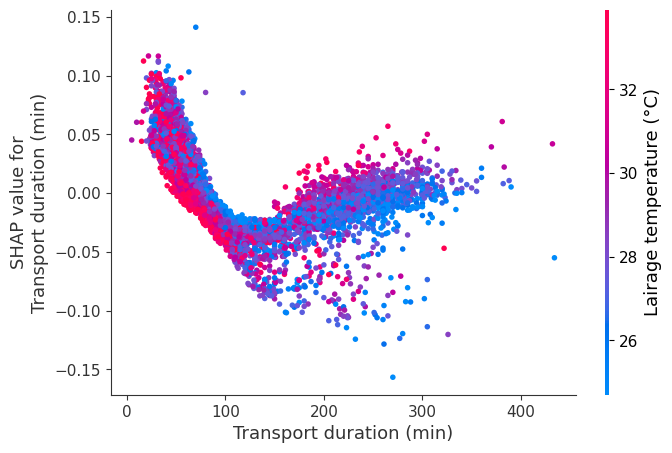

In [52]:
# durationtransport
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=4,  # Feature index for 'durationtransport'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=3, # Lairagetemp
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_durationtrans_Lairagetemp.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

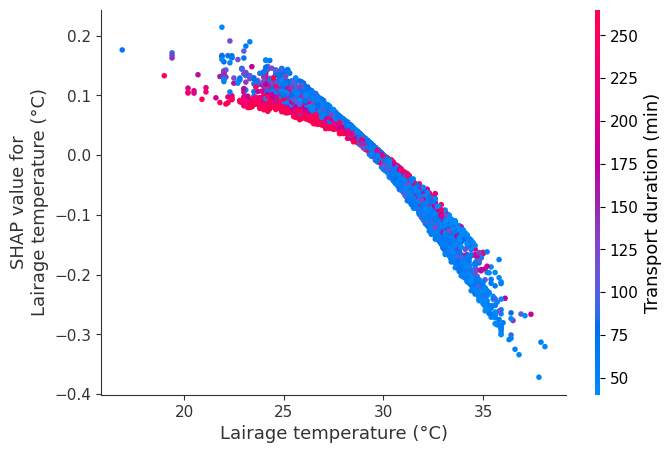

In [55]:
# durationtransport
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=4, #durationtransport
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_durationtrans.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**Lairage temp VS head**

<Figure size 640x480 with 0 Axes>

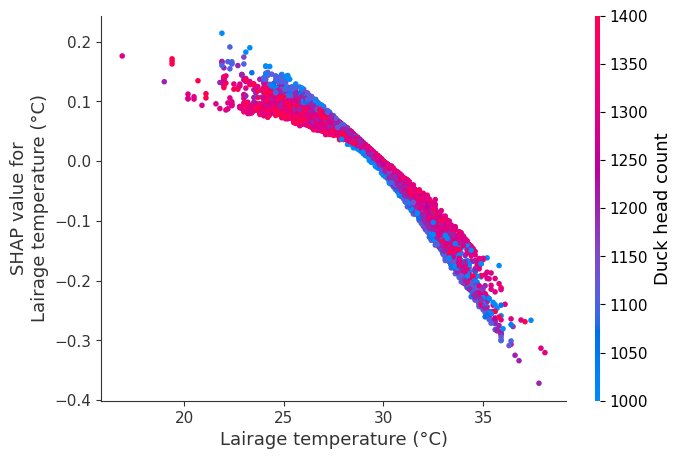

In [54]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=0, # head
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_head.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

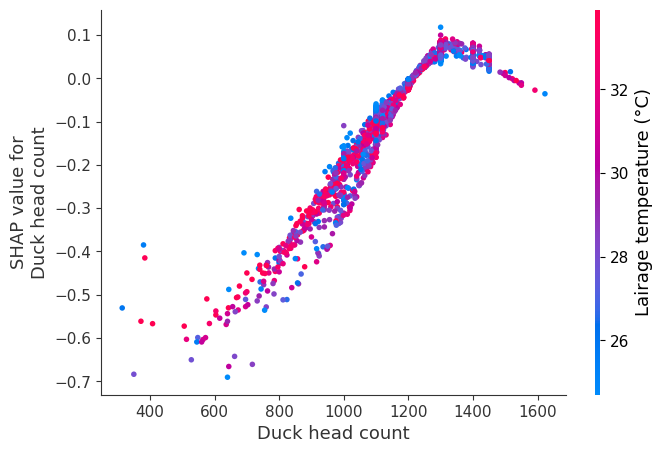

In [56]:
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=0,  # Feature index for 'head'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_renamed,  # Feature dataset
        feature_names=ordered_feature_names,  # List of feature names
        interaction_index=3, #Lairagetemp
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_head_lairagetemp.jpg", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

## **Waterfall plot**

**Highest %DOA**

In [81]:
# ✅ Print top pctdoa values and their index
print("🔍 Top 10 pctdoa values:")
print(df[['pctdoa']].sort_values(by='pctdoa', ascending=False).head(10))

🔍 Top 10 pctdoa values:
        pctdoa
787   6.499261
3397  5.857143
2405  5.138340
7896  4.123711
2350  4.083333
5108  4.008016
7980  4.000000
989   3.980583
6921  3.559028
976   3.525641


In [82]:
row_index = df['pctdoa'].idxmax()
print(f"🔍 Index of max pctdoa: {row_index}")

🔍 Index of max pctdoa: 787


In [83]:
print("🔍 Selected row with max pctdoa:\n", df.loc[[row_index]])

🔍 Selected row with max pctdoa:
           date  order             farm  distance  head  age    bw  \
787 2022-03-14     15  Suvannaphumfarm      95.0   677   42  2.23   

            timeoutfarm          timearrive       slaughtertime  lairagetemp  \
787 1900-01-01 12:35:00 1900-01-01 14:13:00 1900-01-01 16:46:00         34.2   

     doa    pctdoa orderc  season timetransport  durationtransport  \
787   44  6.499261   Late  Summer           Day                 98   

     lairagetime classdoa  
787          153     high  


In [84]:
print(f"🔍 Checking if row index {row_index} exists in X_train_numeric...")
print(f"X_train_numeric shape: {X_train_numeric.shape}")

🔍 Checking if row index 787 exists in X_train_numeric...
X_train_numeric shape: (6576, 10)


In [85]:
print(f"Does row index {row_index} exist in X_train_numeric?")
print(row_index in range(X_train_numeric.shape[0]))  # Should return True

Does row index 787 exist in X_train_numeric?
True


In [86]:
print(f"First 5 indices in df: {df.index[:5].tolist()}")
print(f"First 5 indices in X_train_numeric: {list(range(5))}")

First 5 indices in df: [0, 1, 2, 3, 4]
First 5 indices in X_train_numeric: [0, 1, 2, 3, 4]


In [89]:
# Find the actual position of row index 787 in X_train
row_position = X_train.index.get_loc(787)
print(f"🔍 Correct row position of index 787 in X_train_numeric: {row_position}")

🔍 Correct row position of index 787 in X_train_numeric: 2275


In [90]:
# ✅ Select the correctly mapped row from X_train_numeric
X_sample = X_train_numeric[2275:2276]  # Use 2275 as row position

# ✅ Debug: Print the selected row to confirm correctness
print("🔍 Correct row from X_train_numeric:\n", pd.DataFrame(X_sample, columns=X_train.columns))

🔍 Correct row from X_train_numeric:
     head   age    bw  lairagetemp  durationtransport  lairagetime  \
0  677.0  42.0  2.23    34.200001               98.0        153.0   

   season_Summer  season_Winter  timetransport_Morning  timetransport_Night  
0            1.0            0.0                    0.0                  0.0  


In [96]:
shap_values_sample = explainer(X_sample)
print("✅ SHAP values computed successfully!")

✅ SHAP values computed successfully!


In [97]:
import matplotlib.pyplot as plt

# ✅ Extract SHAP values for class 1 (High DOA)
shap_values_high_class = shap.Explanation(
    values=shap_values_sample.values[0][:, 1],  # Class 1 (index 1)
    base_values=shap_values_sample.base_values[0][1],  # Base value for Class 1
    data=shap_values_sample.data[0],  # Feature values
    feature_names=ordered_feature_names  # Correct feature names
)

# ✅ Debug: Print SHAP explanation data before plotting
print("\n🔍 SHAP Explanation Data for Correct Row (Class 1 - High DOA):")
print(shap_values_high_class)


🔍 SHAP Explanation Data for Correct Row (Class 1 - High DOA):
.values =
array([-4.79886642e-01, -1.60553089e-04, -2.66692201e-02, -1.47878511e-01,
       -1.82039373e-02, -7.21359034e-03,  5.58299959e-04,  3.31804177e-03,
       -3.67618901e-03, -3.07423158e-03])

.base_values =
0.7819184422353282

.data =
array([677.  ,  42.  ,   2.23,  34.2 ,  98.  , 153.  ,   1.  ,   0.  ,
         0.  ,   0.  ], dtype=float32)


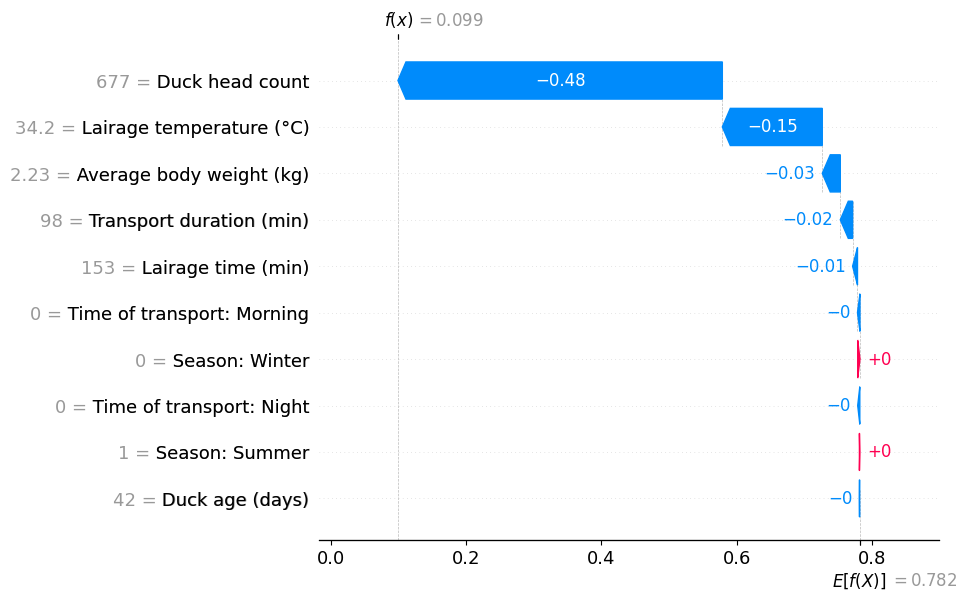

<Figure size 640x480 with 0 Axes>

In [98]:
# ✅ Plot Waterfall Chart for Class 1 (High DOA)
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values_high_class)

# ✅ Save the plot
plt.savefig("shap_waterfall_row_highest.jpg", dpi=600, bbox_inches="tight")
plt.show()

**We can conclude that the model incorrectly classified this case into low DOA ☹**

## **Local explanation example: row #976**

In [114]:
# ✅ Find the actual position of row index 976 in X_train
row_position_976 = X_train.index.get_loc(976)
print(f"🔍 Correct row position of index 976 in X_train_numeric: {row_position_976}")

🔍 Correct row position of index 976 in X_train_numeric: 4016


In [115]:
# ✅ Select the correctly mapped row from X_train_numeric
X_sample_976 = X_train_numeric[4016:4017]

# ✅ Debug: Print the selected row to confirm correctness
print("🔍 Correct row from X_train_numeric:\n", pd.DataFrame(X_sample_976, columns=X_train.columns))

🔍 Correct row from X_train_numeric:
      head   age   bw  lairagetemp  durationtransport  lairagetime  \
0  1248.0  40.0  2.6    31.700001               68.0         59.0   

   season_Summer  season_Winter  timetransport_Morning  timetransport_Night  
0            1.0            0.0                    0.0                  0.0  


In [116]:
# ✅ Compute SHAP values for row 976
shap_values_sample_976 = explainer(X_sample_976)
print("✅ SHAP values computed successfully!")

✅ SHAP values computed successfully!


In [117]:
# ✅ Get the model's prediction for row 976
predicted_proba_976 = fine_tuned_model.predict(X_sample_976)
predicted_class_976 = np.argmax(predicted_proba_976)  # Get the predicted class
print(f"🔍 Model Predicted Class for Row 976: {predicted_class_976}")

# ✅ Extract SHAP values for the predicted class
shap_values_correct_976 = shap.Explanation(
    values=shap_values_sample_976.values[0][:, predicted_class_976],  # Select predicted class
    base_values=shap_values_sample_976.base_values[0][predicted_class_976],  # Base value
    data=shap_values_sample_976.data[0],  # Feature values
    feature_names=ordered_feature_names  # Correct feature names
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
🔍 Model Predicted Class for Row 976: 1


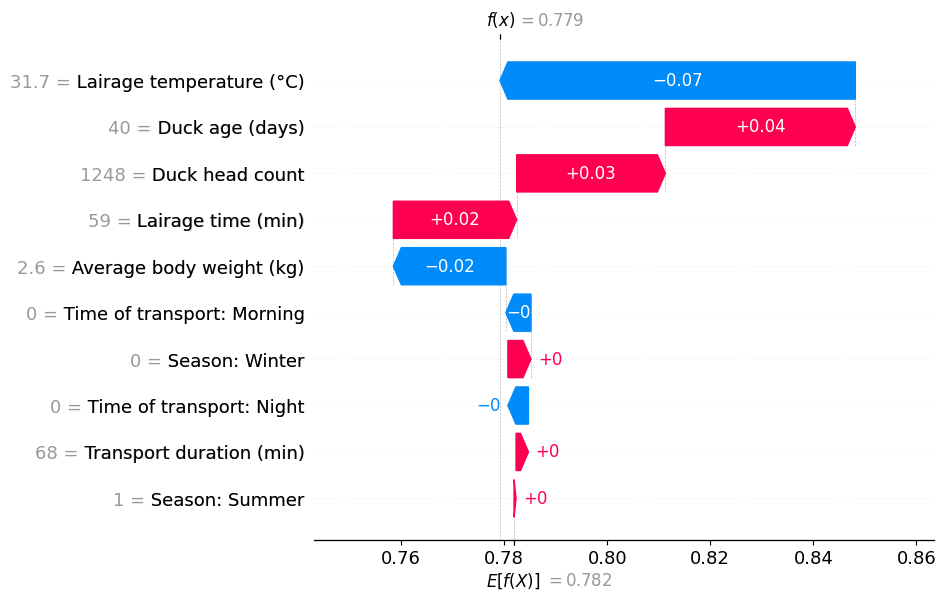

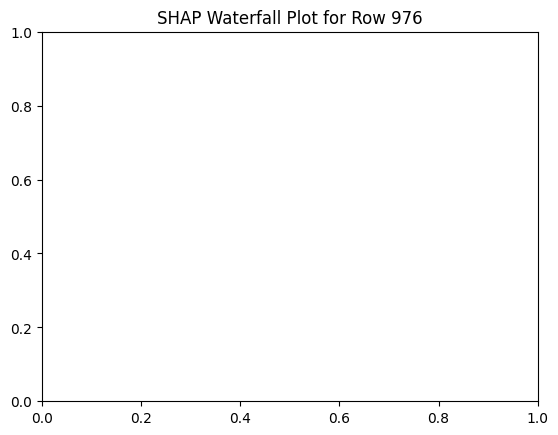

In [119]:
import matplotlib.pyplot as plt

# ✅ Plot the SHAP Waterfall Chart for the predicted class
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values_correct_976)
plt.title(f"SHAP Waterfall Plot for Row 976")

# ✅ Save the plot
plt.savefig("shap_waterfall_row_976.jpg", dpi=600, bbox_inches="tight")
plt.show()

## **Local explanation example: row #123**

In [135]:
# ✅ Find the actual position of row index 123 in X_train
row_position_123 = X_train.index.get_loc(123)
print(f"🔍 Correct row position of index 123 in X_train_numeric: {row_position_123}")

🔍 Correct row position of index 123 in X_train_numeric: 4919


In [136]:
# ✅ Select the correctly mapped row from X_train_numeric
X_sample_123 = X_train_numeric[4919:4920]

# ✅ Debug: Print the selected row to confirm correctness
print("🔍 Correct row from X_train_numeric:\n", pd.DataFrame(X_sample_123, columns=X_train.columns))

🔍 Correct row from X_train_numeric:
      head   age    bw  lairagetemp  durationtransport  lairagetime  \
0  1400.0  44.0  3.24    24.700001              115.0        120.0   

   season_Summer  season_Winter  timetransport_Morning  timetransport_Night  
0            0.0            1.0                    0.0                  1.0  


In [137]:
# ✅ Compute SHAP values for row 123
shap_values_sample_123 = explainer(X_sample_123)
print("✅ SHAP values computed successfully!")

✅ SHAP values computed successfully!


In [138]:
# ✅ Get the model's prediction for row 123
predicted_proba_123 = fine_tuned_model.predict(X_sample_123)
predicted_class_123 = np.argmax(predicted_proba_123)  # Get the predicted class
print(f"🔍 Model Predicted Class for Row 123: {predicted_class_123}")

# ✅ Extract SHAP values for the predicted class
shap_values_correct_123 = shap.Explanation(
    values=shap_values_sample_123.values[0][:, predicted_class_123],  # Select predicted class
    base_values=shap_values_sample_123.base_values[0][predicted_class_123],  # Base value
    data=shap_values_sample_123.data[0],  # Feature values
    feature_names=ordered_feature_names  # Correct feature names
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
🔍 Model Predicted Class for Row 123: 1


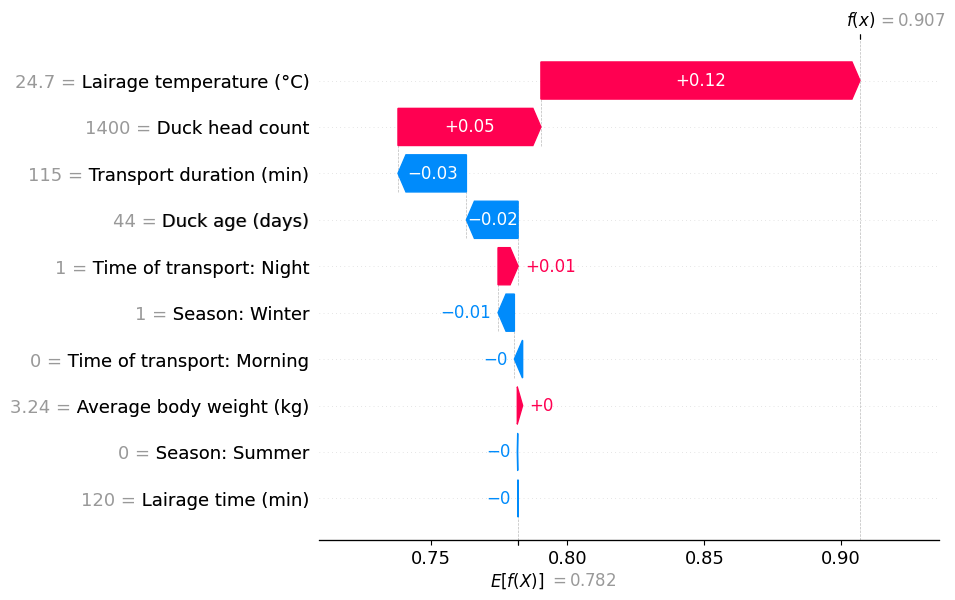

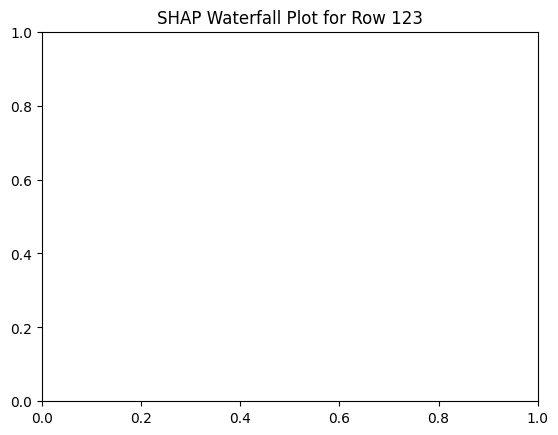

In [139]:
import matplotlib.pyplot as plt

# ✅ Plot the SHAP Waterfall Chart for the predicted class
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values_correct_123)
plt.title(f"SHAP Waterfall Plot for Row 123")

# ✅ Save the plot
plt.savefig("shap_waterfall_row_123.jpg", dpi=600, bbox_inches="tight")
plt.show()

## **Force Plot**

In [128]:
# Calculate the expected value (mean prediction for the 'high' class)
expected_value = np.mean(fine_tuned_model.predict(X_train_renamed)[:, 1])  # Mean probability for the 'high' class

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [129]:
import shap

shap.initjs()  # Initialize JavaScript visualization

In [133]:
import shap
import matplotlib.pyplot as plt

# Select one instance to explain (e.g., the first row of your dataset)
instance_index = 123  # Replace with the row index you want to visualize
shap_values_single_123 = shap_values.values[instance_index, :, 1]  # SHAP values for 'high' class
features_single_123 = X_train_numeric[instance_index, :]  # Feature values for the selected instance

# Generate the force plot
shap.initjs()  # Initialize JavaScript for visualization
force_plot_123 = shap.force_plot(
    base_value=expected_value,  # Manually calculated expected value
    shap_values=shap_values_single_123,  # SHAP values for the selected instance
    features=features_single_123,  # Feature values for the selected instance
    feature_names=ordered_feature_names  # Feature names
)

# Display the plot
force_plot_123

In [134]:
import shap

# Save the force plot as an HTML file
shap.save_html("force_plot_instance_123.html", force_plot_123)

# If using Google Colab, download the file to your local machine
from google.colab import files
files.download("force_plot_instance_123.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Decision Plot**

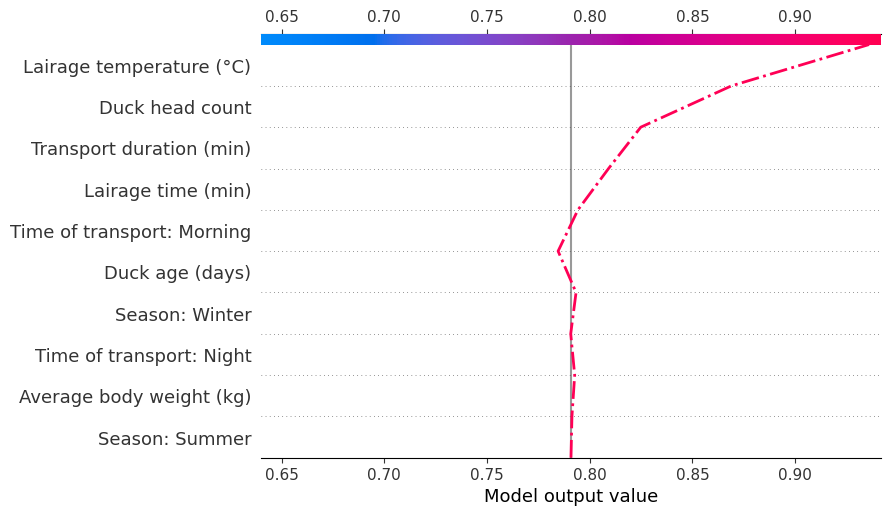

<Figure size 640x480 with 0 Axes>

In [141]:
import shap
import matplotlib.pyplot as plt

# Select an instance to explain (e.g., the first row)
instance_index = 123  # Replace with the desired row index

# Generate a decision plot
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[instance_index, :, 1],  # SHAP values for the 'high' class
    feature_names=ordered_feature_names,             # Feature names
    feature_order="importance",              # Optional: Order features by importance
    highlight=0                              # Optional: Highlight the selected instance
)

# Save the plot with high resolution
plt.savefig("decision_plot_row123.jpg", dpi=600, bbox_inches="tight")

# Display the plot
plt.show()

**All instances**

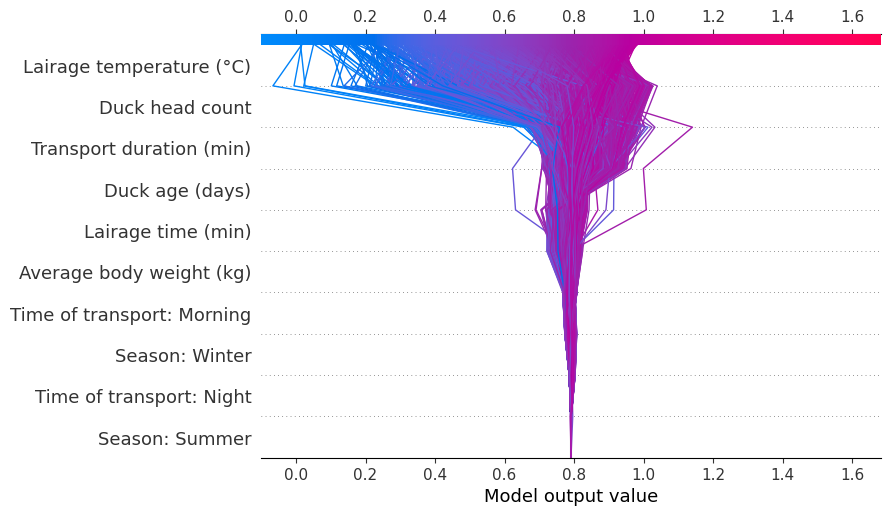

<Figure size 640x480 with 0 Axes>

In [143]:
import shap
import matplotlib.pyplot as plt

# ✅ Increase figure size
plt.figure(figsize=(15, 8))

# Generate a decision plot for all instances
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[:, :, 1],  # SHAP values for the 'high' class (all instances)
    feature_names=ordered_feature_names,             # Feature names
    feature_order="importance",              # Order features by importance
    ignore_warnings=True                     # Ignore warnings about large datasets
)

# Save the plot with high resolution
plt.savefig("decision_plot_all_instance.jpg", dpi=600, bbox_inches="tight")

plt.show()

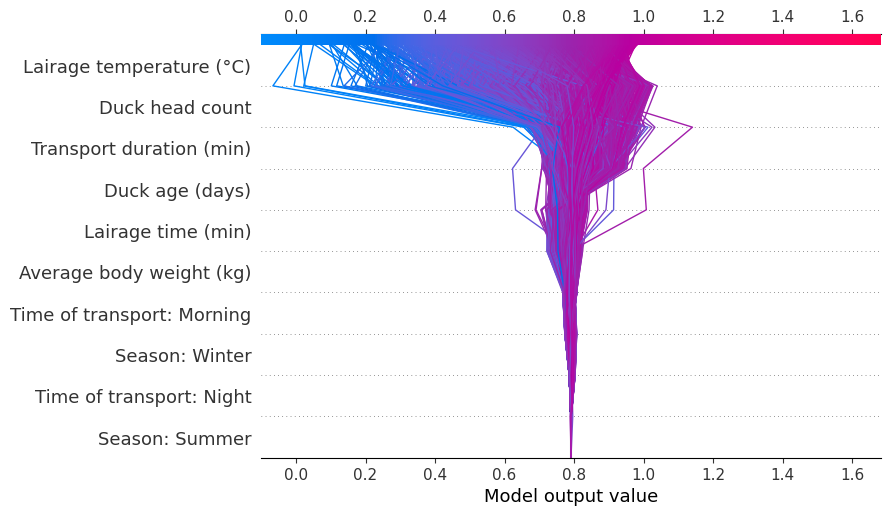

<Figure size 1500x800 with 0 Axes>

In [144]:
import shap
import matplotlib.pyplot as plt

# ✅ Set global figure size
plt.rcParams["figure.figsize"] = (15, 8)  # Set width and height

# ✅ Generate a decision plot for all instances
shap.decision_plot(
    base_value=expected_value,                # Manually calculated expected value
    shap_values=shap_values.values[:, :, 1],  # SHAP values for the 'high' class (all instances)
    feature_names=ordered_feature_names,      # Feature names
    feature_order="importance",               # Order features by importance
    ignore_warnings=True                      # Ignore warnings about large datasets
)

# ✅ Save the plot with high resolution
plt.savefig("decision_plot_all_instance2.jpg", dpi=600, bbox_inches="tight")

# ✅ Show in Colab
plt.show()

# **Save files & Make the work reproducible**
remove # for running the code

In [145]:
#!pip freeze > requirements.txt

In [146]:
#from google.colab import files
#files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [147]:
#os.listdir()

['.config',
 'shap_waterfall_row_976.jpg',
 'dependence_lairagetemp_head.jpg',
 'shap_waterfall_row_787.jpg',
 'shap_waterfall_row_correct.jpg',
 'shap_waterfall_row_123.jpg',
 'force_plot_instance_123.html',
 'dependence_durationtrans_Lairagetemp.jpg',
 'dependence_head_lairagetemp.jpg',
 'decision_plot_row123.jpg',
 'DOA-data_65-66_for_NN.xlsx',
 'shap_summary_plot_beeswarm2.jpg',
 '.ipynb_checkpoints',
 'decision_plot_all_instance2.jpg',
 'decision_plot_row123.png',
 'dependence_lairagetemp_durationtrans.jpg',
 'shap_force_plot.html',
 'decision_plot_all_instance.jpg',
 'shap_waterfall_row_highest.jpg',
 'requirements.txt',
 'sample_data']

In [150]:
#!zip -r project_journal.zip *

  adding: decision_plot_all_instance2.jpg (deflated 100%)
  adding: decision_plot_all_instance.jpg (deflated 100%)
  adding: decision_plot_row123.jpg (deflated 100%)
  adding: decision_plot_row123.png (deflated 99%)
  adding: dependence_durationtrans_Lairagetemp.jpg (deflated 34%)
  adding: dependence_head_lairagetemp.jpg (deflated 44%)
  adding: dependence_lairagetemp_durationtrans.jpg (deflated 45%)
  adding: dependence_lairagetemp_head.jpg (deflated 46%)
  adding: DOA-data_65-66_for_NN.xlsx (deflated 0%)
  adding: force_plot_instance_123.html (deflated 68%)
  adding: project_baseline.zip (stored 0%)
  adding: requirements.txt (deflated 57%)
  adding: sample_data/ (stored 0%)
  adding: sample_data/README.md (deflated 39%)
  adding: sample_data/anscombe.json (deflated 83%)
  adding: sample_data/california_housing_train.csv (deflated 79%)
  adding: sample_data/mnist_train_small.csv (deflated 88%)
  adding: sample_data/mnist_test.csv (deflated 88%)
  adding: sample_data/california_housi

In [151]:
#from google.colab import files
#files.download("project_journal.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Reproduce the Environment**

In [16]:
#pip install -r requirements.txt


### ▶ ALL DONE ◀



